### ResNet50 Model

References:

https://towardsdatascience.com/understand-and-implement-resnet-50-with-tensorflow-2-0-1190b9b52691

https://github.com/suvoooo/Learn-TensorFlow/blob/master/resnet/Implement_Resnet_TensorFlow.ipynb

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import  Rectangle
import tensorflow as tf

import os
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPool2D,MaxPooling2D, Flatten,BatchNormalization, Dropout,ZeroPadding2D, AveragePooling2D, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import activations
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

from tensorflow.keras.datasets import cifar10
from keras.utils import to_categorical

import time

Using TensorFlow backend.


In [23]:
 #Removing all regularizers

def res_identity(x, filters, num_batchnorm = 0, num_dropout=0, dropout_prob = 0, dropout_prob_array=[]):
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters
  bn = num_batchnorm
  drp = num_dropout

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  if bn>0:
    x = BatchNormalization()(x)
    bn-=1
  x = Activation(activations.relu)(x)
  if drp>0:
    x = Dropout(dropout_prob_array[0])(x)
    drp-=1

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
  if bn>0:
    x = BatchNormalization()(x)
    bn-=1
  x = Activation(activations.relu)(x)
  if drp>0:
    x = Dropout(dropout_prob_array[1])(x)
    drp-=1

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  if bn>0:
    x = BatchNormalization()(x)
    bn-=1
  x = Activation(activations.relu)(x)
  if drp>0:
    x = Dropout(dropout_prob_array[2])(x)
    drp-=1

  # add the input 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)


  return x

def res_conv(x, s, filters, num_batchnorm = 0, num_dropout=0, dropout_prob = 0, dropout_prob_array=[]):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters
  bn = num_batchnorm
  drp = num_dropout

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid')(x)
  # when s = 2 then it is like downsizing the feature map
  if bn>0:
    x = BatchNormalization()(x)
    bn-=1
  x = Activation(activations.relu)(x)
  if drp>0:
    x = Dropout(dropout_prob_array[1])(x)
    drp-=1

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
  if bn>0:
    x = BatchNormalization()(x)
    bn-=1
  x = Activation(activations.relu)(x)
  if drp>0:
    x = Dropout(dropout_prob_array[2])(x)
    drp-=1

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  if bn>0:
    x = BatchNormalization()(x)
    bn-=1

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid')(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

def resnet50(num_batchnorm = 0, bn_pooling = False, dropout_prob=0, dropout_prob_array = [], num_dropout_conv = 0, num_dropout_id = 0, num_dropout=0):

  input_im = Input(shape=(32, 32, 3)) # cifar 10 images size
  x = ZeroPadding2D(padding=(3, 3))(input_im)
  bn = num_batchnorm
  drp = num_dropout

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  if bn_pooling:
    x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)
  if drp>0:
    x = Dropout(dropout_prob_array[0])(x)
    drp-=1

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256),num_batchnorm=bn, num_dropout = num_dropout_conv, dropout_prob = dropout_prob, dropout_prob_array=dropout_prob_array)
  x = res_identity(x, filters=(64, 256),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob, dropout_prob_array=dropout_prob_array)
  x = res_identity(x, filters=(64, 256),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob, dropout_prob_array=dropout_prob_array)

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512),num_batchnorm=bn, num_dropout = num_dropout_conv, dropout_prob = dropout_prob, dropout_prob_array=dropout_prob_array)
  x = res_identity(x, filters=(128, 512),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob, dropout_prob_array=dropout_prob_array)
  x = res_identity(x, filters=(128, 512),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob, dropout_prob_array=dropout_prob_array)
  x = res_identity(x, filters=(128, 512),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob, dropout_prob_array=dropout_prob_array)

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_conv, dropout_prob = dropout_prob, dropout_prob_array=dropout_prob_array)
  x = res_identity(x, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob, dropout_prob_array=dropout_prob_array)
  x = res_identity(x, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob, dropout_prob_array=dropout_prob_array)
  x = res_identity(x, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob, dropout_prob_array=dropout_prob_array)
  x = res_identity(x, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob, dropout_prob_array=dropout_prob_array)
  x = res_identity(x, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob, dropout_prob_array=dropout_prob_array)

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048),num_batchnorm=bn, num_dropout = num_dropout_conv, dropout_prob = dropout_prob, dropout_prob_array=dropout_prob_array)
  x = res_identity(x, filters=(512, 2048),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob, dropout_prob_array=dropout_prob_array)
  x = res_identity(x, filters=(512, 2048),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob, dropout_prob_array=dropout_prob_array)

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  if drp>0:
    x = Dropout(dropout_prob_array[0])(x)
    drp-=1
  x = Dense(10, activation='softmax')(x) #multi-class

  # define the model 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

In [24]:
import pickle

In [25]:
#to measure Time to Accuracy
#https://keras.io/guides/writing_your_own_callbacks/

class timeToAccuracy(keras.callbacks.Callback):
    def __init__(self, startTime, epoch_ckpt, model_name):
        super(timeToAccuracy, self).__init__()
        self.targetAcc = 0.87 #CHANGE TO 0.87 WHEN RUNNING MODEL
        self.foundTarget = False
        self.startTime = startTime
        self.epoch = 0
        self.epoch_ckpt = epoch_ckpt
        self.model_name = model_name
        self.prev_loss = None
    def on_epoch_end(self, epoch, logs=None):
        if self.epoch % self.epoch_ckpt == 0:
            print(self.epoch, epoch)
            name = self.model_name + '.h5'
            self.model.save_weights(name)
            print('end', logs)
            
        self.epoch += 1
#         if (self.prev_loss == None):
#             self.prev_loss = logs['loss']
#         else:
#             delta = np.abs(logs['loss'] - self.prev_loss)
        if not self.foundTarget:
            if logs['accuracy'] >= self.targetAcc:
                current = time.time()
                print("Time to reach {} accuracy: {} s".format(self.targetAcc, current-self.startTime))
                with open('{}_tta.pkl'.format(model_name), 'wb') as file:
                    pickle.dump(current-self.startTime, file)
                self.foundTarget = True

In [26]:
def fit_resnet(model, xtrain, ytrain, xtest, ytest, model_name, convergence=False):
  
    EPOCHS = 500 if convergence else 100     #Change to 200 when running the model
    BATCH_SIZE= 256
    VERBOSITY = 0   #Change to 0 when actually running model
    EPOCH_CKPT = 15 # save model every N epochs

    opt = keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=['accuracy'])
    #fit the model
    start = time.time()
    print('Fitting with BS ', BATCH_SIZE)
#     es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20) if convergence else None
    model.fit(
        xtrain,
        ytrain,
        batch_size=BATCH_SIZE,
        verbose=VERBOSITY,
        epochs = EPOCHS,
        callbacks=[timeToAccuracy(startTime=start, epoch_ckpt=EPOCH_CKPT, model_name=model_name)]
    )
    train_time = time.time() - start

    #evaluate
    score = model.evaluate(xtest,ytest)
    loss = score[0]
    acc = score[1]

    return train_time,  acc

In [27]:
#prepare data

(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

# Data normalization
x_train = x_train/255
x_test = x_test/255
y_train = to_categorical(y_train) 
y_test = to_categorical(y_test)

In [28]:
dropout_prob_array=[
    [0.2,0.5,0.8],
    [0.5,0.2,0.2],
    [0.2,0.5,0.2],
    [0.5,0.5,0.2],
    [0.1,0.2,0.3],
    [0.3,0.2,0.1],
]
dp = 3
bn = 2

for arr in dropout_prob_array:
    print('Training BN{}, DPID{}, DPCONV{}, DPPROB{}'.format(bn, dp, dp, arr))
    model_name = 'model_bn{}_dpid_{}_dpconv_{}_dpprob_{}'.format(bn, dp, dp, str(arr))
    resnet_model = resnet50(
        num_batchnorm=bn,
        bn_pooling=True,
        num_dropout_conv=dp,
        num_dropout_id=dp,
#         dropout_prob=prob, 
        dropout_prob_array=arr
    )
    tt, acc = fit_resnet(resnet_model,x_train, y_train, x_test, y_test, model_name)

    print('Final accuracy {} reached in {}'.format(acc, tt))

Training BN2, DPID3, DPCONV3, DPPROB[0.2, 0.5, 0.8]
Fitting with BS  256
0 0
end {'loss': 2.8245654106140137, 'accuracy': 0.14552000164985657}
15 15
end {'loss': 1.0125149488449097, 'accuracy': 0.6394400000572205}
30 30
end {'loss': 0.6597040891647339, 'accuracy': 0.7688400149345398}
45 45
end {'loss': 0.43369731307029724, 'accuracy': 0.8476999998092651}
Time to reach 0.87 accuracy: 471.8229331970215 s
60 60
end {'loss': 0.25791946053504944, 'accuracy': 0.9094200134277344}
75 75
end {'loss': 0.16233089566230774, 'accuracy': 0.9433599710464478}
90 90
end {'loss': 0.27793821692466736, 'accuracy': 0.9162200093269348}
313/313 [==============================] - 4s 11ms/step - loss: 1.2762 - accuracy: 0.7049
Final accuracy 0.7049000263214111 reached in 876.6220529079437
Training BN2, DPID3, DPCONV3, DPPROB[0.5, 0.2, 0.2]
Fitting with BS  256
0 0
end {'loss': 2.048828601837158, 'accuracy': 0.3345400094985962}
15 15
end {'loss': 0.48290780186653137, 'accuracy': 0.8289200067520142}
Time to reac

In [29]:
dropout_prob_array=[
    [0.1,0.15,0.25],
    [0.05, 0.1, 0.15],
    [0.09, 0.29, 0.59],
]
dp = 3
bn = 2

for arr in dropout_prob_array:
    print('Training BN{}, DPID{}, DPCONV{}, DPPROB{}'.format(bn, dp, dp, arr))
    model_name = 'model_bn{}_dpid_{}_dpconv_{}_dpprob_{}'.format(bn, dp, dp, str(arr))
    resnet_model = resnet50(
        num_batchnorm=bn,
        bn_pooling=True,
        num_dropout_conv=dp,
        num_dropout_id=dp,
#         dropout_prob=prob, 
        dropout_prob_array=arr
    )
    tt, acc = fit_resnet(resnet_model,x_train, y_train, x_test, y_test, model_name)

    print('Final accuracy {} reached in {}'.format(acc, tt))

Training BN2, DPID3, DPCONV3, DPPROB[0.1, 0.15, 0.25]
Fitting with BS  256
0 0
end {'loss': 1.891187071800232, 'accuracy': 0.38067999482154846}
15 15
end {'loss': 0.3409976065158844, 'accuracy': 0.8772799968719482}
Time to reach 0.87 accuracy: 140.53654289245605 s
30 30
end {'loss': 0.1258680820465088, 'accuracy': 0.956279993057251}
45 45
end {'loss': 0.09529784321784973, 'accuracy': 0.9682599902153015}
60 60
end {'loss': 0.048838019371032715, 'accuracy': 0.9841600060462952}
75 75
end {'loss': 0.05079131945967674, 'accuracy': 0.9831200242042542}
90 90
end {'loss': 0.0386514887213707, 'accuracy': 0.9864400029182434}
313/313 [==============================] - 4s 10ms/step - loss: 1.4404 - accuracy: 0.7506
Final accuracy 0.7505999803543091 reached in 846.3317098617554
Training BN2, DPID3, DPCONV3, DPPROB[0.05, 0.1, 0.15]
Fitting with BS  256
0 0
end {'loss': 1.9078837633132935, 'accuracy': 0.39921998977661133}
Time to reach 0.87 accuracy: 104.93711543083191 s
15 15
end {'loss': 0.21184292

In [1]:
import matplotlib.pyplot as plt

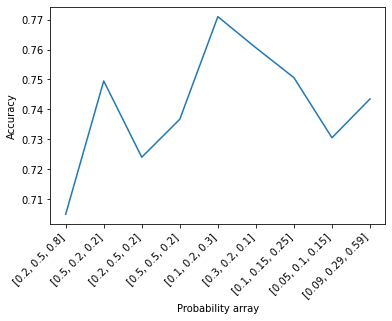

In [20]:
dropout_prob_array=[
    [0.2,0.5,0.8],
    [0.5,0.2,0.2],
    [0.2,0.5,0.2],
    [0.5,0.5,0.2],
    [0.1,0.2,0.3],
    [0.3,0.2,0.1],
    [0.1,0.15,0.25],
    [0.05, 0.1, 0.15],
    [0.09, 0.29, 0.59],
]

values = [
    0.7049000263214111,
    0.7494999766349792,
    0.7239999771118164,
    0.7366999983787537,
    0.7710000276565552,
    0.7605999708175659,
    0.7505999803543091,
    0.7304999828338623,
    0.7434999942779541
]

plt.plot(range(len(values)), values)
plt.xticks(range(len(values)), dropout_prob_array)
plt.xticks(rotation=45, ha="right")
plt.ylabel('Accuracy')
plt.xlabel('Probability array')

plt.savefig('probcombos.jpg', bbox_inches = 'tight')

plt.show()


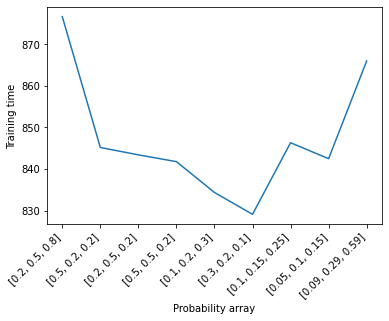

In [21]:
training_times = [
    876.6220529079437,
    845.18665766716,
    843.4118311405182,
    841.7836611270905,
    834.3750269412994,
    829.1241753101349,
    846.3317098617554,
    842.4940419197083,
    865.9739141464233,
]

plt.plot(range(len(training_times)), training_times)
plt.xticks(range(len(training_times)), dropout_prob_array)
plt.xticks(rotation=45, ha="right")
plt.ylabel('Training time')
plt.xlabel('Probability array')

plt.savefig('probcombos_time.jpg', bbox_inches = 'tight')

plt.show()